## Sử dụng data augmentation
Overfitting xảy ra do có quá ít samples để model học, khiến chúng ta không thể train được 1 model có khả năng học tổng quát với data mới. Nếu lượng data là vô hạn, model sẽ nhìn được tất cả các mặt của sự phân bố data, qua đó sẽ không xảy ra overfit. Data augmentation là phương pháp tạo thêm data mới từ tập data có sẵn, bằng cách ra tăng các samples qua một số phép biết đổi ( transformation) . Mục tiêu là trong quá trình training, model sẽ không gặp phải 1 bức ảnh đến 2 lần. Điều này giúp model bao quát data tốt hơn và tổng quát hơn .

Trong keras, ta có thể tùy chỉnh số phép biến đổi thực hiện trên các ảnh bằng ImageDataGenerator :

In [3]:
from keras.preprocessing.image import ImageDataGenerator

In [4]:
datagen = ImageDataGenerator(rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

Còn nhiều option nữa có thể lựa chọn ( Xem [Keras Doc](https://keras.io/preprocessing/image/)). Giải thích cell code trên :
- rotation_range : random xoay ảnh trong khoảng (0-range) độ (range trong khoảng 0-180)
- width_shift & height shift : ta sẽ ngẫu nhiên dịch ảnh trong theo chiều ngang / dọc trong khoảng đó (số này là độ lớn khoảng dịch / chiều rộng (hoặc dài))
- shear_range để ngẫu nhiên sử dụng [shearing transformations](https://www.tutorialspoint.com/computer_graphics/2d_transformation.htm)
- zoom_range : khoảng random để zoom vào ảnh
- horizontal_flips : ngẫu nhiên xoay ảnh theo chiều ngang ( lưu ý 1 số trường hợp như biển rẽ trái/rẽ phải không nên sử dụng )
- fill_mode : cách fill vào các pixel mới tạo ( xuất hiện trong các phép xoay, dịch chuyển ... )

In [5]:
# khoi tao lai cac directory :
import os

base_dir = '/home/thanh/Keras-Learning/Chap5-CNN/small'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir,'test')

train_cats_dir = os.path.join(train_dir,'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')
validation_cats_dir = os.path.join(validation_dir,'cats')
validation_dogs_dir = os.path.join(validation_dir,'dogs')
test_cats_dir = os.path.join(test_dir,'cats')
test_dogs_dir = os.path.join(test_dir,'dogs')

Xem lại các ảnh trong phép augmentation :

In [8]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [ ]:
fnames = [os.path.join(train_cats_dir, fname) for fname
         in os.listdir(train_cats_dir)] # list file 

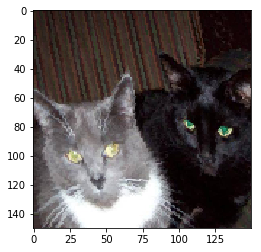

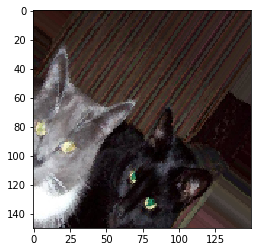

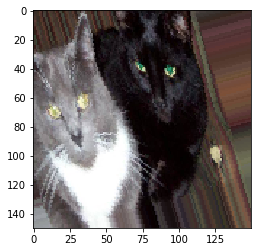

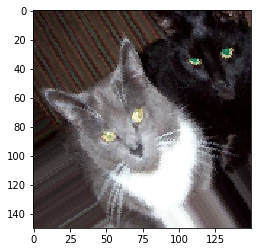

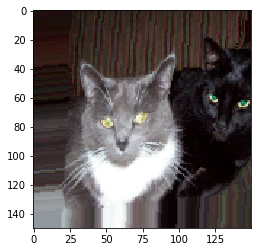

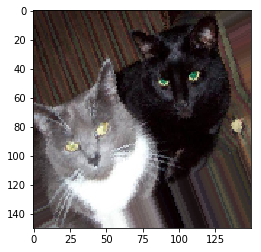

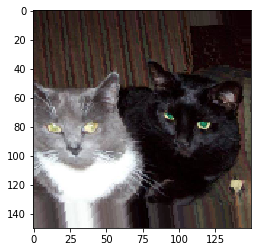

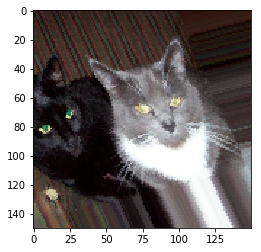

In [11]:
img_path = fnames[4] # lay 1 anh
img = image.load_img(img_path,target_size=(150,150)) # load & resize anh
x = image.img_to_array(img) # convert anh sang numpy array voi shape(150,150,3)
x = x.reshape((1,)+ x.shape) # reshape (1,150,150,3) 

# .flow() tạo các batches của các ảnh đã transform
# nó sẽ không ngừng tạo --> ta cần sử dụng break

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i+=1
    if i%8 == 0 :
        break

plt.show()

Nếu ta train 1 network mới sử dụng data augmentation, network đó sẽ không phải nhìn lại 1 ảnh 2 lần. Tuy vậy, các ảnh input vẫn khá tương đồng ( do được sinh ra từ một số ảnh ) --> Ta không thể tạo thêm đặc tính mới, mà chỉ trộn lại các đặc tính đã có. Do vậy, nó chưa đủ để hoàn toàn không overfitting. Để giảm đỡ overfitting, ta sử dụng thêm Dropout layer cho model, ngay trước dense layer ( layer làm nhiệm vụ classify)

In [14]:
from keras import models, layers
from keras.optimizers import RMSprop

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))


In [15]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

### It's training time :p

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,)

# Lưu ý rằng validation data không sử dụng augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150,150), 
    batch_size=32, 
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory( 
    test_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [19]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 80s - loss: 0.6902 - acc: 0.5212 - val_loss: 0.6792 - val_acc: 0.5812
Epoch 2/100
100/100 [==============================] - 49s - loss: 0.6727 - acc: 0.5844 - val_loss: 0.6691 - val_acc: 0.5812
Epoch 3/100
100/100 [==============================] - 48s - loss: 0.6652 - acc: 0.5969 - val_loss: 0.6373 - val_acc: 0.6546
Epoch 4/100
100/100 [==============================] - 48s - loss: 0.6337 - acc: 0.6334 - val_loss: 0.6260 - val_acc: 0.6347
Epoch 5/100
100/100 [==============================] - 49s - loss: 0.6256 - acc: 0.6441 - val_loss: 0.5985 - val_acc: 0.6875
Epoch 6/100
100/100 [==============================] - 48s - loss: 0.6081 - acc: 0.6662 - val_loss: 0.6253 - val_acc: 0.6320
Epoch 7/100
100/100 [==============================] - 49s - loss: 0.5899 - acc: 0.6791 - val_loss: 0.5913 - val_acc: 0.6732
Epoch 8/100
100/100 [==============================] - 49s - loss: 0.5959 - acc: 0.6747 - val_loss: 0.5727 - val_acc: 0.6992


100/100 [==============================] - 48s - loss: 0.4087 - acc: 0.8144 - val_loss: 0.4541 - val_acc: 0.7957
Epoch 67/100
100/100 [==============================] - 48s - loss: 0.4106 - acc: 0.8025 - val_loss: 0.4366 - val_acc: 0.8028
Epoch 68/100
100/100 [==============================] - 48s - loss: 0.3994 - acc: 0.8153 - val_loss: 0.4597 - val_acc: 0.7983
Epoch 69/100
100/100 [==============================] - 48s - loss: 0.3954 - acc: 0.8197 - val_loss: 0.4761 - val_acc: 0.7951
Epoch 70/100
100/100 [==============================] - 48s - loss: 0.3970 - acc: 0.8219 - val_loss: 0.4821 - val_acc: 0.7811
Epoch 71/100
100/100 [==============================] - 48s - loss: 0.3926 - acc: 0.8188 - val_loss: 0.4994 - val_acc: 0.7824
Epoch 72/100
100/100 [==============================] - 48s - loss: 0.3791 - acc: 0.8234 - val_loss: 0.4459 - val_acc: 0.8020
Epoch 73/100
100/100 [==============================] - 48s - loss: 0.3952 - acc: 0.8216 - val_loss: 0.4680 - val_acc: 0.8001
Epoch

In [20]:
model.save('cats_and_dogs_small_2.h5')

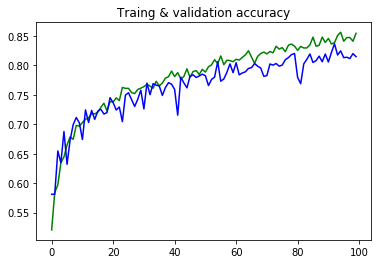

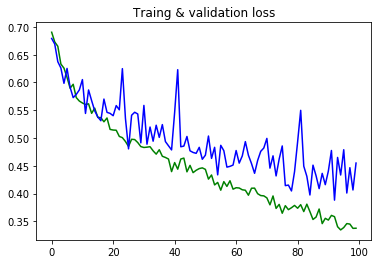

In [25]:
# plot result
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'g')
plt.plot(epochs, val_acc,'b')
plt.title('Traing & validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'g')
plt.plot(epochs, val_loss,'b')
plt.title('Traing & validation loss')

plt.show()
# green :  training, blue : validation

Nhờ data augmentation, chúng ta đã không còn overfitting. Đường training theo sát với đường validating. Model chúng ta có độ chính xác ~ 80%, cải thiện 13% so với model không sử dụng regularized

Bằng cách sử dụng các phương pháp regularizations, cũng như tuning các network parameters ( chỉnh số filters mỗi conv layer, số layers trong network... ) ta có thể đạt độ chính xác lên tới 80 - 82 %. Tuy vậy, model sẽ không cải thiện thêm nhiều nếu chúng ta train từ đầu, bởi vì ta có quá ít data.  Trong 2 mục tiếp theo, ta sẽ nâng cao độ chính xác, ta sẽ làm quen với 1 model đã train ( pre-trained model) 